# ML Surrogates for Chemical ODEs in Astrochemistry
Welcome! In this notebook, we simulate a simple astrochemical ODE system and train three different ML models to approximate its behavior:
- Feedforward Neural Network (FNN)
- Neural ODE
- Deep Operator Network (DeepONet)

We'll compare their performance as surrogates for the underlying physical dynamics.

**Author:** Lorenzo Branca  
**Date:** August 2025

In [ ]:
import subprocess
import sys

def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

install("jax")
install("diffrax")
install("optax")
install("flax")

In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from diffrax import diffeqsolve, Dopri5, ODETerm, SaveAt
import optax
%matplotlib inline

## Simulating a Chemical Reaction System

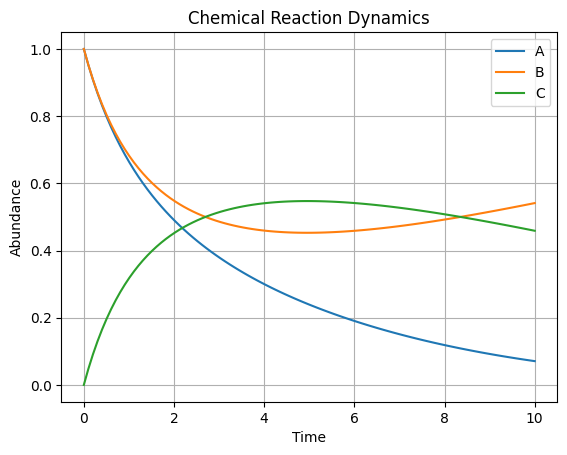

In [9]:
def reaction_system(t, y, args):
    A, B, C = y
    k1, k2 = args
    dA = -k1 * A * B
    dB = -k1 * A * B + k2 * C
    dC = k1 * A * B - k2 * C
    return jnp.array([dA, dB, dC])

y0 = jnp.array([1.0, 1.0, 0.0])

 
k1, k2 = 0.5, 0.1
    
t0, t1 = 0.0, 10.0
ts = jnp.linspace(t0, t1, 100)

term = ODETerm(reaction_system)
solver = Dopri5()
saveat = SaveAt(ts=ts)
sol = diffeqsolve(term, solver, t0=t0, t1=t1, dt0=0.1, y0=y0, args=(k1,k2), saveat=saveat)

plt.plot(ts, sol.ys[:, 0], label="A")
plt.plot(ts, sol.ys[:, 1], label="B")
plt.plot(ts, sol.ys[:, 2], label="C")
plt.xlabel("Time")
plt.ylabel("Abundance")
plt.title("Chemical Reaction Dynamics")
plt.legend()
plt.grid(True)

## Generate Training Data

In [11]:
def generate_dataset(n_samples=200, key=jax.random.PRNGKey(0)):
    ic_list, sol_list = [], []

    # Sample random initial conditions in [0, 1]^3
    ic_samples = jax.random.uniform(key, shape=(n_samples, 3), minval=0.0, maxval=1.0)

    for i in range(n_samples):
        y0 = ic_samples[i]
        sol = diffeqsolve(term, solver, t0=t0, t1=t1, dt0=0.1, y0=y0, args=(k1, k2), saveat=saveat)
        ic_list.append(y0)
        sol_list.append(sol.ys)

    return jnp.stack(ic_list), ts[None, :].repeat(n_samples, axis=0), jnp.stack(sol_list)

ICs, Ts, Ys = generate_dataset(n_samples= 1024)

## Next Steps

Now that we have generated the data, we will:

1. Implement and train a **Feedforward Neural Network (FNN)**.
2. Implement and train a **Neural ODE** model.
3. Implement and train a **DeepONet** model.
4. Compare their performance.

⬇️ Continue by implementing the FNN model below ⬇️

## 🔧 Implementing the Feedforward Neural Network (FNN)
We'll use a simple MLP that takes `[IC, t]` as input and predicts `[A, B, C]`.

In [12]:
from flax import linen as nn
from dataclasses import field
from typing import List

class FNN(nn.Module):
    hidden_dims: List[int] = field(default_factory=lambda: [128, 128, 128])

    @nn.compact
    def __call__(self, ic, t):
        B, N = t.shape
        x = jnp.concatenate([jnp.repeat(ic[:, None, :], N, axis=1), t[:, :, None]], axis=-1)
        x = x.reshape(-1, x.shape[-1])  # (B*N, features)
        for h in self.hidden_dims:
            x = nn.relu(nn.Dense(h)(x))
        out = nn.Dense(3)(x)
        return out.reshape(B, N, 3)

### 🔁 Training loop for FNN

In [13]:
import optax
from flax.training import train_state

class TrainState(train_state.TrainState):
    pass

def create_train_state(rng, model, lr=1e-3):
    params = model.init(rng, ICs[:1], Ts[:1])['params']
    tx = optax.adam(learning_rate=lr)
    return TrainState.create(apply_fn=model.apply, params=params, tx=tx)

def loss_fn(params, apply_fn, ic, t, y_true):
    y_pred = apply_fn({'params': params}, ic, t)
    return jnp.mean((y_pred - y_true)**2)

@jax.jit
def train_step(state, ic, t, y_true):
    grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = grad_fn(state.params, state.apply_fn, ic, t, y_true)
    return state.apply_gradients(grads=grads), loss

### 🚀 Train the model

In [14]:
rng = jax.random.PRNGKey(0)
model = FNN()
state = create_train_state(rng, model)

n_epochs = 41
batch_size = 32
losses = []

for epoch in range(n_epochs):
    idx = jax.random.permutation(rng, ICs.shape[0])
    ICs_shuffled, Ts_shuffled, Ys_shuffled = ICs[idx], Ts[idx], Ys[idx]

    epoch_loss = 0.0
    for i in range(0, ICs.shape[0], batch_size):
        ic_batch = ICs_shuffled[i:i+batch_size]
        t_batch = Ts_shuffled[i:i+batch_size]
        y_batch = Ys_shuffled[i:i+batch_size]
        state, loss = train_step(state, ic_batch, t_batch, y_batch)
        epoch_loss += loss

    epoch_loss /= (ICs.shape[0] // batch_size)
    losses.append(epoch_loss)
    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss = {epoch_loss:.4e}")

Epoch 0, Loss = 1.0175e-01
Epoch 20, Loss = 2.4363e-04
Epoch 40, Loss = 2.0998e-04
Epoch 60, Loss = 2.7467e-04
Epoch 80, Loss = 1.6897e-04
Epoch 100, Loss = 7.0865e-05


### 📈 Visualize predictions vs. ground truth

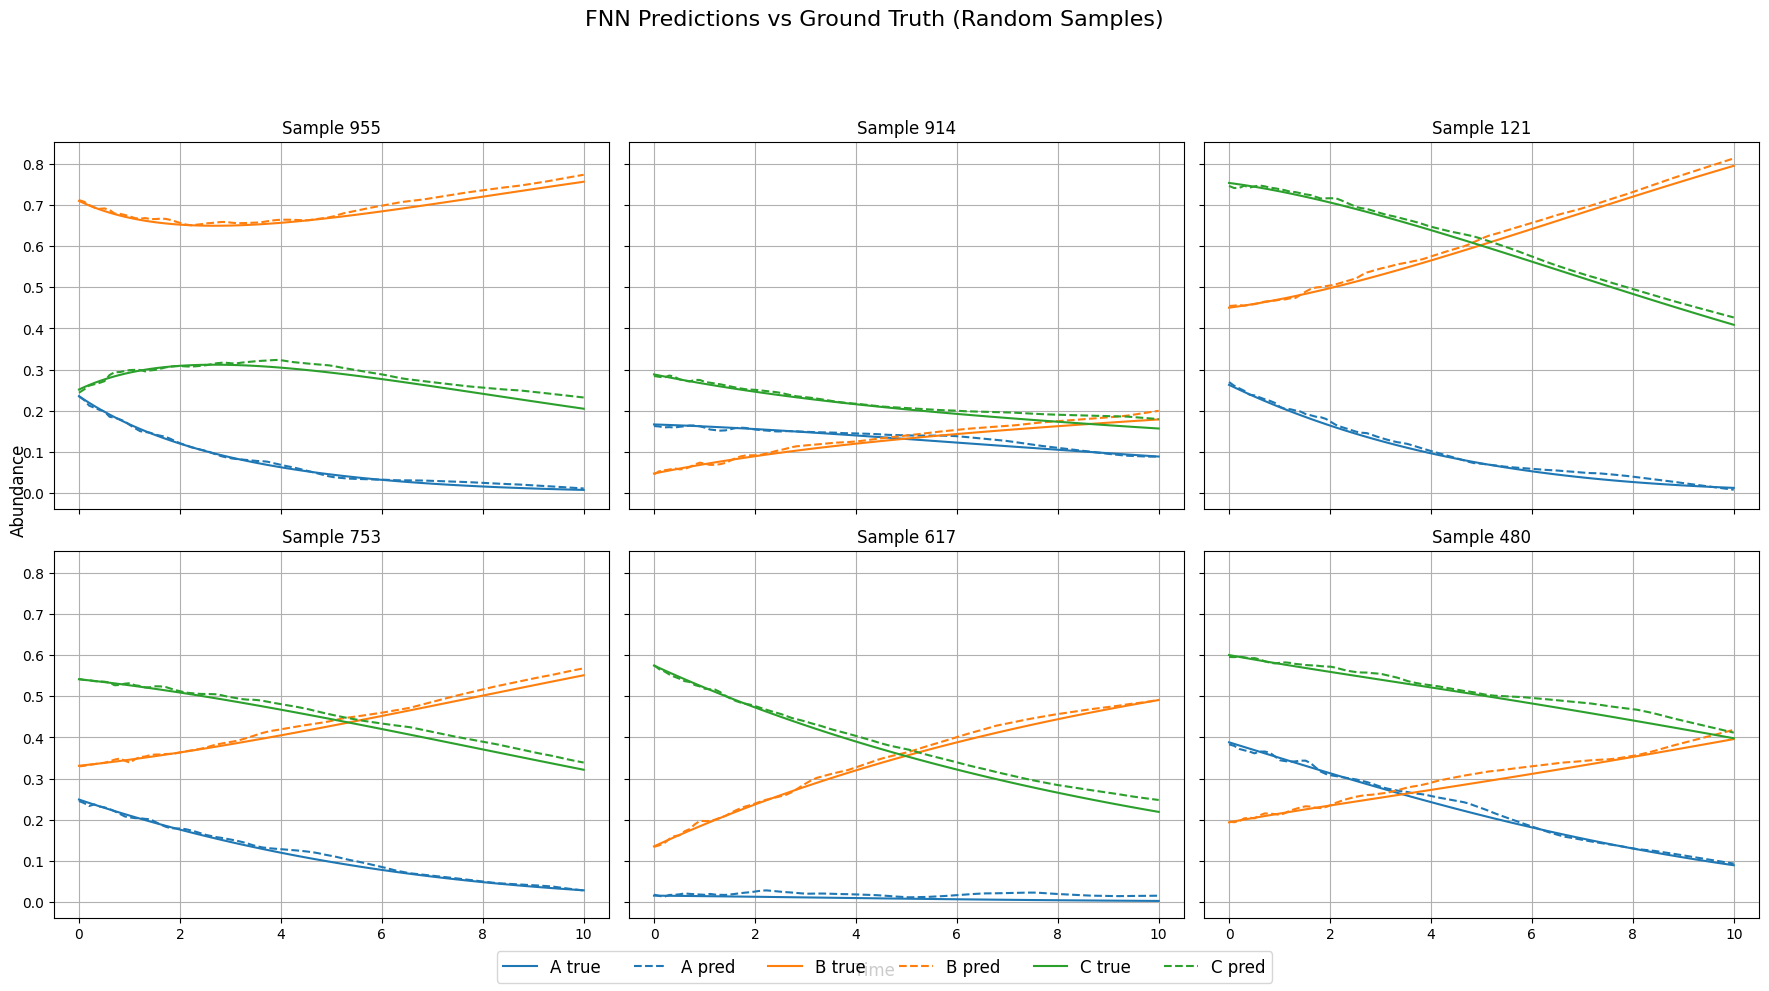

In [19]:
n_samples = 6
key = jax.random.PRNGKey(42)

# Generate random, non-repeating sample indices
sample_idxs = jax.random.choice(key, len(ICs), shape=(n_samples,), replace=False)

# Setup plot
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=True, sharey=True)
axes = axes.flatten()

colors = ['tab:blue', 'tab:orange', 'tab:green']
labels = ['A', 'B', 'C']

for ax, idx in zip(axes, sample_idxs):
    idx = int(idx)  # Convert JAX array element to Python int
    ic_test = ICs[idx:idx+1]
    t_test = Ts[idx:idx+1]
    y_true = Ys[idx]
    y_pred = model.apply({'params': state.params}, ic_test, t_test)[0]

    for i in range(3):
        ax.plot(ts, y_true[:, i], color=colors[i], label=f"{labels[i]} true")
        ax.plot(ts, y_pred[:, i], '--', color=colors[i], label=f"{labels[i]} pred")

    ax.set_title(f"Sample {idx}")
    ax.grid(True)

# Single legend
handles, legend_labels = axes[0].get_legend_handles_labels()
fig.legend(handles, legend_labels, loc='lower center', ncol=6, fontsize=12)

fig.suptitle("FNN Predictions vs Ground Truth (Random Samples)", fontsize=16)
fig.supxlabel("Time")
fig.supylabel("Abundance")
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()


## 🧠 Implementing the Neural ODE Surrogate
We will define a neural network as the right-hand side of the ODE system and use it inside a `diffrax` solver.

In [20]:
class NeuralODEFunc(nn.Module):
    hidden_dims: List[int] = field(default_factory=lambda: [64, 64])

    @nn.compact
    def __call__(self, t, y, args=None):
        x = y
        for h in self.hidden_dims:
            x = nn.relu(nn.Dense(h)(x))
        return nn.Dense(3)(x)

In [21]:
def solve_neural_ode(rhs_net, params, y0, ts):
    term = ODETerm(lambda t, y, args: rhs_net.apply({'params': params}, t, y))
    solver = Dopri5() # play with rtol and atol
    saveat = SaveAt(ts=ts)
    sol = diffeqsolve(term, solver, t0=ts[0], t1=ts[-1], dt0=0.1, y0=y0, saveat=saveat)
    return sol.ys

In [22]:
# Initialize
neural_ode_model = NeuralODEFunc()
rng, key = jax.random.split(rng)
neural_ode_params = neural_ode_model.init(key, 0.0, jnp.array([1.0, 1.0, 0.0]))['params']

optimizer = optax.adam(1e-3)
opt_state = optimizer.init(neural_ode_params)

In [23]:
from functools import partial


@jax.jit
def ode_loss_fn(params, model, y0, ts, y_true):
    pred_y = solve_neural_ode(model, params, y0, ts)
    return jnp.mean((pred_y - y_true) ** 2)

def make_ode_train_step(model):
    @jax.jit
    def ode_train_step(params, opt_state, y0_batch, ts, y_batch):
        def loss_fn(params):
            pred_y = solve_neural_ode(model, params, y0_batch, ts)  # shape: (T, B, D)
            pred_y = jnp.swapaxes(pred_y, 0, 1)  # -> shape: (B, T, D), to match y_batch
            return jnp.mean((pred_y - y_batch) ** 2)
        loss, grads = jax.value_and_grad(loss_fn)(params)
        updates, opt_state = optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss
    return ode_train_step


In [25]:
n_epochs = 41
ode_losses = []

# Compile this only once before training loop
ode_train_step = make_ode_train_step(neural_ode_model)


for epoch in range(n_epochs):
    epoch_loss = 0.0
    for i in range(0, ICs.shape[0], batch_size):
        ic_batch = ICs[i : i + batch_size]   
        y_batch = Ys[i : i + batch_size]    

        neural_ode_params, opt_state, loss = ode_train_step(
            neural_ode_params, opt_state, ic_batch, ts, y_batch
        )

        epoch_loss += loss

    epoch_loss /= (ICs.shape[0] // batch_size)
    ode_losses.append(epoch_loss)

    if epoch % 20 == 0:
        print(f"[NeuralODE] Epoch {epoch}, Loss = {epoch_loss:.4e}")


[NeuralODE] Epoch 0, Loss = 5.5405e-05
[NeuralODE] Epoch 20, Loss = 8.2366e-05
[NeuralODE] Epoch 40, Loss = 4.3770e-05


KeyboardInterrupt: 

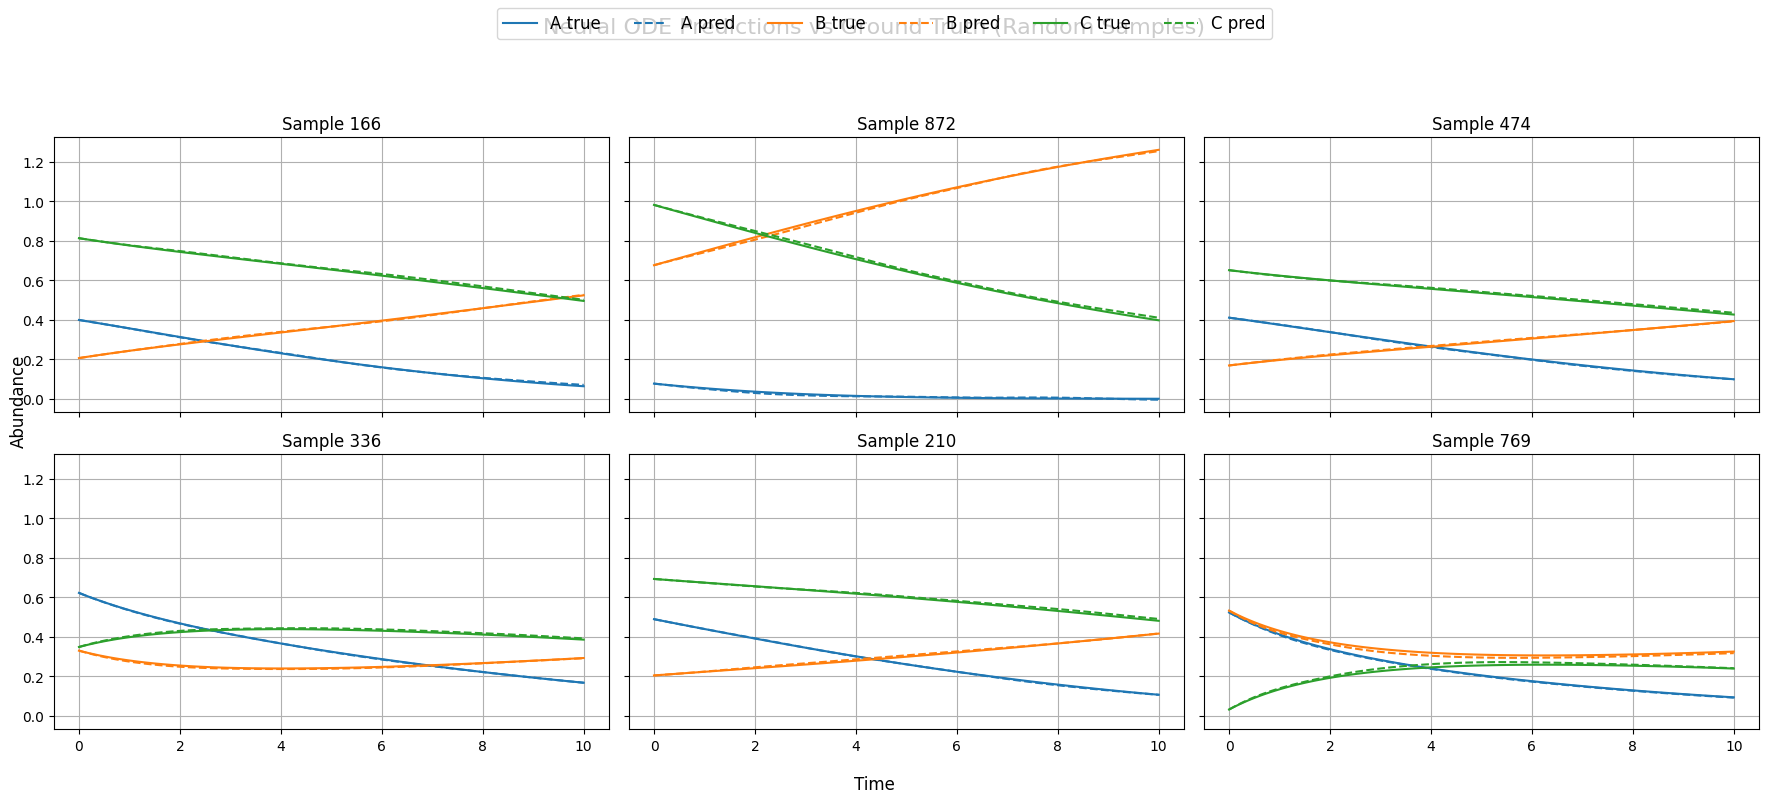

In [26]:
n_samples = 6
key = jax.random.PRNGKey(0)
sample_idxs = jax.random.choice(key, len(ICs), shape=(n_samples,), replace=False)

# Setup plot grid
fig, axes = plt.subplots(2, 3, figsize=(18, 8), sharex=True, sharey=True)
axes = axes.flatten()

colors = ['tab:blue', 'tab:orange', 'tab:green']
labels = ['A', 'B', 'C']

for ax, idx in zip(axes, sample_idxs):
    idx = int(idx)  # Convert JAX int to Python int
    y0_test = ICs[idx]
    y_true = Ys[idx]
    y_pred = solve_neural_ode(neural_ode_model, neural_ode_params, y0_test, ts)

    for i in range(3):
        ax.plot(ts, y_true[:, i], color=colors[i], label=f"{labels[i]} true")
        ax.plot(ts, y_pred[:, i], '--', color=colors[i], label=f"{labels[i]} pred")

    ax.set_title(f"Sample {idx}")
    ax.grid(True)

# Shared legend
handles, legend_labels = axes[0].get_legend_handles_labels()
fig.legend(handles, legend_labels, loc='upper center', ncol=6, fontsize=12)

fig.suptitle("Neural ODE Predictions vs Ground Truth (Random Samples)", fontsize=16)
fig.supxlabel("Time")
fig.supylabel("Abundance")
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()

## 🧬 Implementing DeepONet


In [27]:
import jax.numpy as jnp
from flax import linen as nn
from typing import Callable, Tuple

class MLP(nn.Module):
    features: Tuple[int, ...]
    activation: Callable = nn.relu

    @nn.compact
    def __call__(self, x):
        for feat in self.features[:-1]:
            x = self.activation(nn.Dense(feat)(x))
        return nn.Dense(self.features[-1])(x)

class DeepONet(nn.Module):
    branch_layers: Tuple[int, ...] = (128, 128, 128)
    trunk_layers: Tuple[int, ...] = (128, 128, 128)
    latent_dim: int = 128
    output_dim: int = 3
    activation: Callable = nn.tanh

    def setup(self):
        trunk_features = self.trunk_layers + (self.latent_dim,)
        self.trunk_net = MLP(features=trunk_features, activation=self.activation)

        # Define 3 separate branch networks
        self.branch_nets = [
            MLP(features=self.branch_layers + (self.latent_dim,), activation=self.activation)
            for _ in range(self.output_dim)
        ]

    @nn.compact
    def __call__(self, ic, t):
        B, N = t.shape  # B=batch size, N=time points
        trunk_in = t.reshape(-1, 1)  # (B*N, 1)
        trunk_out = self.trunk_net(trunk_in).reshape(B, N, self.latent_dim)  # (B, N, D)

        # For each branch network, compute output and dot with trunk
        outputs = []
        for branch_net in self.branch_nets:
            branch_out = branch_net(ic).reshape(B, self.latent_dim)  # (B, D)
            y = jnp.einsum("bnd,bd->bn", trunk_out, branch_out)  # (B, N)
            outputs.append(y[..., None])  # (B, N, 1)

        return jnp.concatenate(outputs, axis=-1)  # (B, N, 3)



In [28]:
deeponet_model = DeepONet()
deeponet_state = create_train_state(rng, deeponet_model)

def deeponet_loss_fn(params, ic, t, y_true):
    y_pred = deeponet_model.apply({'params': params}, ic, t)
    return jnp.mean((y_pred - y_true) ** 2)

@jax.jit
def deeponet_train_step(state, ic, t, y_true):
    loss, grads = jax.value_and_grad(deeponet_loss_fn)(state.params, ic, t, y_true)
    return state.apply_gradients(grads=grads), loss

In [29]:
n_epochs = 41
deeponet_losses = []

for epoch in range(n_epochs):
    epoch_loss = 0.0
    for i in range(0, ICs.shape[0], batch_size):
        ic_batch = ICs[i:i+batch_size]
        t_batch = Ts[i:i+batch_size]
        y_batch = Ys[i:i+batch_size]
        deeponet_state, loss = deeponet_train_step(deeponet_state, ic_batch, t_batch, y_batch)
        epoch_loss += loss
    epoch_loss /= (ICs.shape[0] // batch_size)
    deeponet_losses.append(epoch_loss)
    if epoch % 20 == 0:
        print(f"[DeepONet] Epoch {epoch}, Loss = {epoch_loss:.4e}")

[DeepONet] Epoch 0, Loss = 1.3680e+00
[DeepONet] Epoch 20, Loss = 4.0996e-04
[DeepONet] Epoch 40, Loss = 3.5201e-04


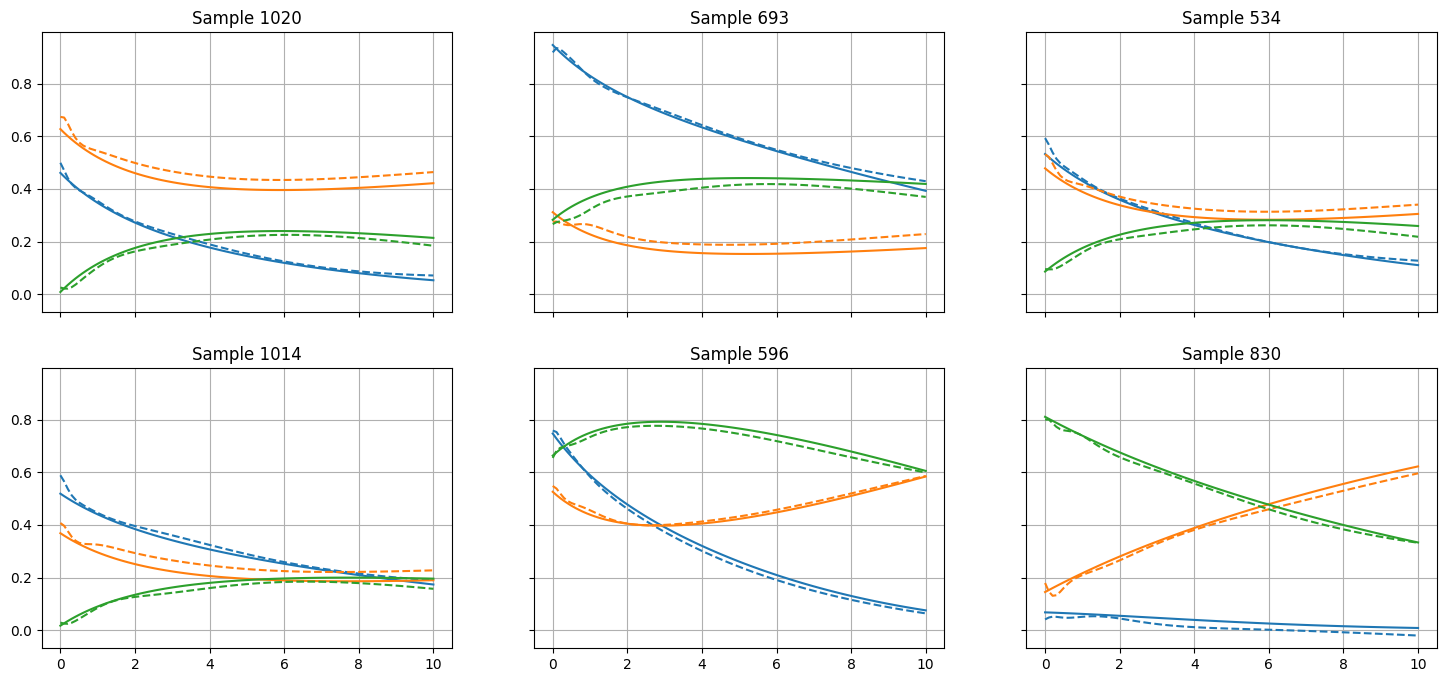

In [30]:
n_samples = 6
key = jax.random.PRNGKey(123)
sample_idxs = jax.random.choice(key, len(ICs), shape=(n_samples,), replace=False)

# Set up subplot grid
fig, axes = plt.subplots(2, 3, figsize=(18, 8), sharex=True, sharey=True)
axes = axes.flatten()

colors = ['tab:blue', 'tab:orange', 'tab:green']
labels = ['A', 'B', 'C']

for ax, idx in zip(axes, sample_idxs):
    idx = int(idx)
    ic_test = ICs[idx:idx+1]     # shape [1, input_dim]
    t_test = Ts[idx:idx+1]       # shape [1, T, 1]
    y_true = Ys[idx]             # shape [T, 3]

    # Predict using DeepONet
    y_pred = deeponet_model.apply({'params': deeponet_state.params}, ic_test, t_test)[0]

    for i in range(3):
        ax.plot(ts, y_true[:, i], color=colors[i], label=f"{labels[i]} true")
        ax.plot(ts, y_pred[:, i], '--', color=colors[i], label=f"{labels[i]} pred")

    ax.set_title(f"Sample {idx}")
    ax.grid(True)

## 🧬 Implementing PI-DeepONet


In [31]:
def physics_residual(params, ic_batch, t_batch, args):
    """
    ic_batch: (B, 3)
    t_batch:  (B, N)
    Returns:  (B, N, 3)
    """
    def residual_single(ic_single, t_single):
        # y_fn: R -> R^3
        def y_fn(tt):
            tt = tt[None, None]  # (1, 1)
            return deeponet_model.apply({'params': params}, ic_single[None, :], tt)[0, 0, :]

        # dy/dt via Jacobian
        dy_dt = jax.vmap(jax.jacrev(y_fn))(t_single)  # (N, 3)

        # Predicted y for all times
        y_pred = deeponet_model.apply({'params': params}, ic_single[None, :], t_single[None, :])[0]  # (N, 3)

        # ODE RHS for predicted y
        rhs = jax.vmap(lambda y: reaction_system(0.0, y, args))(y_pred)  # (N, 3)

        return dy_dt - rhs  # (N, 3)

    # Map over batch (B)
    return jax.vmap(residual_single, in_axes=(0, 0))(ic_batch, t_batch)


In [32]:
def deeponet_loss_fn_physics(params, ic, t, y_true, args, lambda_phys=1.0):
    # Data loss
    y_pred = deeponet_model.apply({'params': params}, ic, t)
    data_loss = jnp.mean((y_pred - y_true) ** 2)

    # Physics loss
    residuals = physics_residual(params, ic, t, args)  # (B, N, 3)
    phys_loss = jnp.mean(residuals ** 2)

    return data_loss + lambda_phys * phys_loss


@jax.jit
def deeponet_train_step_physics(state, ic, t, y_true, args, lambda_phys=1.0):
    loss_fn = lambda p: deeponet_loss_fn_physics(p, ic, t, y_true, args, lambda_phys)
    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    return state.apply_gradients(grads=grads), loss


In [33]:
lambda_phys = 0.1  # weight for physics loss

n_epochs = 41
batch_size = 32

deeponet_model = DeepONet()
deeponet_state = create_train_state(rng, deeponet_model)

for epoch in range(n_epochs):
    epoch_loss = 0.0
    for i in range(0, ICs.shape[0] - batch_size + 1, batch_size):
        ic_batch = ICs[i:i+batch_size]
        t_batch = Ts[i:i+batch_size]
        y_batch = Ys[i:i+batch_size]
        deeponet_state, loss = deeponet_train_step_physics(
            deeponet_state, ic_batch, t_batch, y_batch, args=(k1, k2), lambda_phys=lambda_phys
        )
        epoch_loss += loss
    epoch_loss /= (ICs.shape[0] // batch_size)
    if epoch % 20 == 0:
        print(f"[DeepONet-Physics] Epoch {epoch}, Loss = {epoch_loss:.4e}")


[DeepONet-Physics] Epoch 0, Loss = 2.3076e+00
[DeepONet-Physics] Epoch 20, Loss = 6.1916e-04
[DeepONet-Physics] Epoch 40, Loss = 3.0516e-04


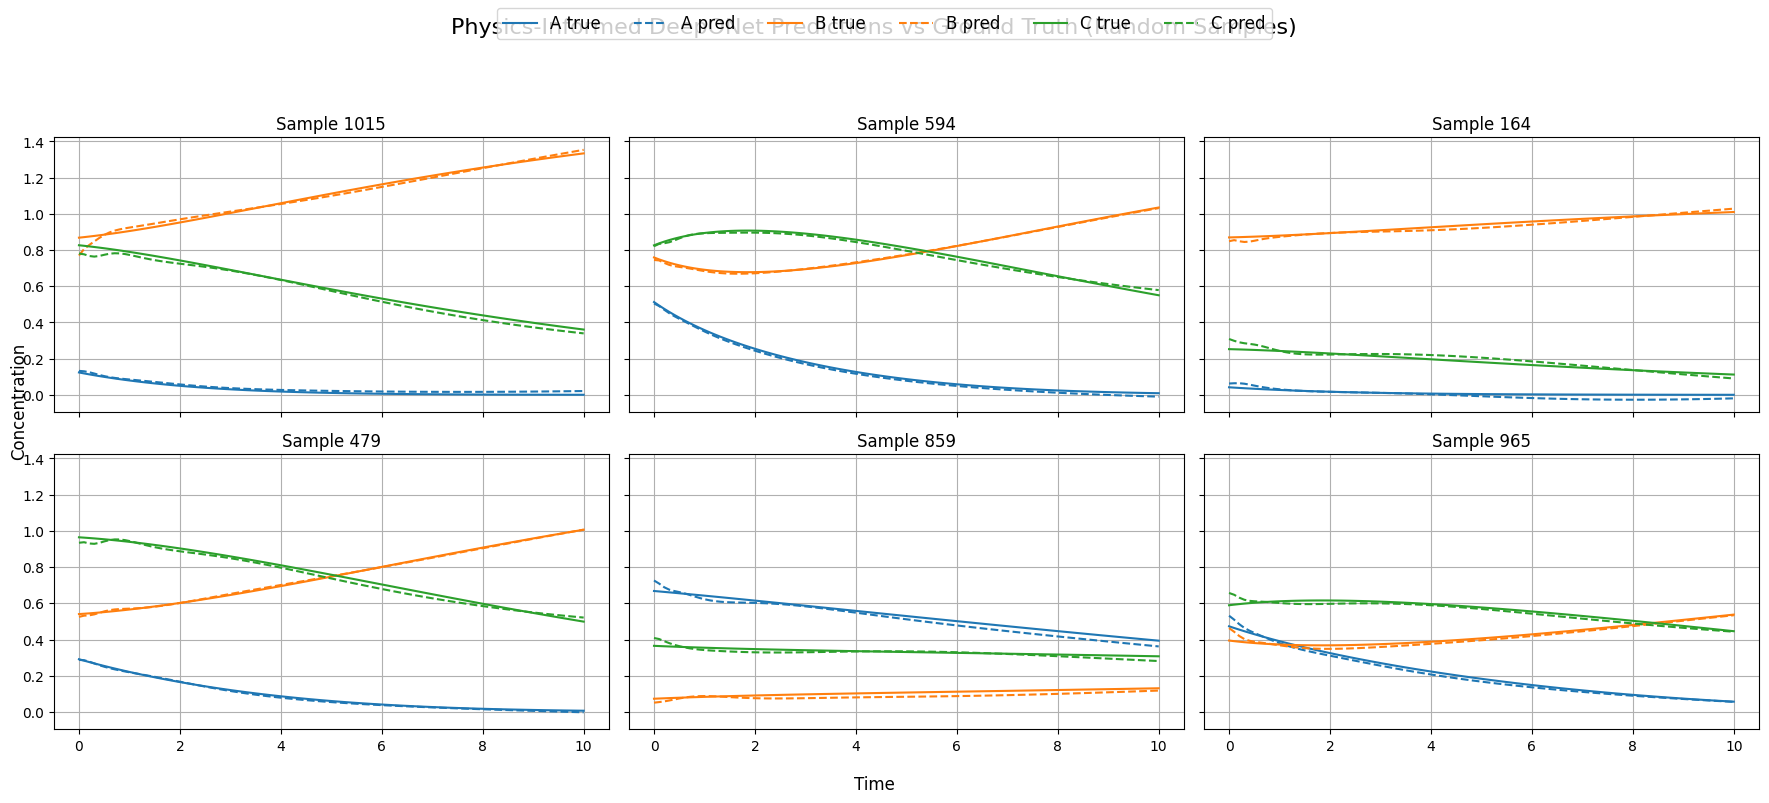

In [34]:
n_samples = 6
key = jax.random.PRNGKey(456)
sample_idxs = jax.random.choice(key, len(ICs), shape=(n_samples,), replace=False)

# Plot setup: 2 rows × 3 columns
fig, axes = plt.subplots(2, 3, figsize=(18, 8), sharex=True, sharey=True)
axes = axes.flatten()

colors = ['tab:blue', 'tab:orange', 'tab:green']
labels = ['A', 'B', 'C']

for ax, idx in zip(axes, sample_idxs):
    idx = int(idx)
    ic_test = ICs[idx:idx+1]     # shape (1, 3)
    t_test = Ts[idx:idx+1]       # shape (1, T, 1)
    y_true = Ys[idx]             # shape (T, 3)

    y_pred = deeponet_model.apply(
        {'params': deeponet_state.params}, 
        ic_test, 
        t_test
    )[0]  # shape (T, 3)

    for i in range(3):
        ax.plot(ts, y_true[:, i], color=colors[i], label=f"{labels[i]} true")
        ax.plot(ts, y_pred[:, i], '--', color=colors[i], label=f"{labels[i]} pred")

    ax.set_title(f"Sample {idx}")
    ax.grid(True)

# One shared legend above all subplots
handles, legend_labels = axes[0].get_legend_handles_labels()
fig.legend(handles, legend_labels, loc='upper center', ncol=6, fontsize=12)

# Shared title and axis labels
fig.suptitle("Physics-Informed DeepONet Predictions vs Ground Truth (Random Samples)", fontsize=16)
fig.supxlabel("Time")
fig.supylabel("Concentration")
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()
